In [1]:
import pandas as pd
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import numpy as np

In [2]:
# Create a spark session
spark = (
    SparkSession.builder.appName("Predict fraud probabilities")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "8g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/09 15:24:24 WARN Utils: Your hostname, Shromanns-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.12.131.179 instead (on interface en0)
22/10/09 15:24:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/09 15:24:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark.read.parquet('../../../data/curated/process_data.parquet').printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tag: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- rate: double (nullable = true)
 |-- category: string (nullable = true)
 |-- subcategory: string (nullable = true)
 |-- merchant_fraud_probability: double (nullable = true)
 |-- user_fraud_probability: double (nullable = true)
 |-- estimated_region_population_2021_sum: long (nullable = true)
 |-- persons_earners_2018-19_sum: double (nullable = true)
 |-- mean_earnings_2018-19_avg: double (nullable = true)
 |-- sum_earnings_2018-19_sum: double (nullable = true)
 |-- median_earnings_2018-19_avg: double (n

In [4]:
# these are our predictors
base_features = {'dollar_value',
                 'gender',
                 'revenue',
                 'rate'}

#user_feature = {'user_fraud_probability'}
#merchant_feature = {'merchant_fraud_probability'}

target_features = {'user_fraud_probability', 'merchant_fraud_probability'}


subset = base_features.union(target_features)
print(subset)

{'rate', 'dollar_value', 'revenue', 'merchant_fraud_probability', 'gender', 'user_fraud_probability'}


In [5]:
data = spark.read.parquet('../../../data/curated/process_data.parquet').select(*subset)
#user_data = data.na.drop(subset=['user_fraud_probab
# ility'])
#merchant_data = data.na.drop(subset=['merchant_fraud_probability'])

In [6]:
def get_weights(df1, label, n):

    # drop rows with missing label
    df = df1.na.drop(subset=[label]).toPandas()

    # find bins
    df['bin'] = pd.cut(df[label], n)

    # get weights and create mapper
    d = df.groupby('bin').count()[label].map(np.log)
    d = d.sum() / d
    mapper = d.to_dict()

    # create weights col mapped from bins
    df['weights'] = df['bin'].map(lambda x: mapper[x])

    weighted_df = spark.createDataFrame(df.drop('bin', axis=1))

    return weighted_df


In [7]:
ud = get_weights(data, 'user_fraud_probability', 10)

In [8]:
md = get_weights(data, 'merchant_fraud_probability', 5)

In [9]:
md.limit(10)

rate,dollar_value,revenue,merchant_fraud_probability,gender,user_fraud_probability,weights
0.0465,169.88,b,0.3,Male,0.08,2.584837324122583
0.0341,151.79,b,0.31,Male,NaN,2.584837324122583
0.0341,449.27,b,0.31,Male,NaN,2.584837324122583
0.0203,392.99,c,0.29,Female,NaN,2.584837324122583
0.0664,39.63,a,0.28,Male,NaN,2.584837324122583
0.0176,246.29,c,0.28,Female,NaN,2.584837324122583
0.0565,87.97,a,0.31,Male,NaN,2.584837324122583
0.0176,144.65,c,0.29,Undisclosed,NaN,2.584837324122583
0.0664,306.38,a,0.28,Female,NaN,2.584837324122583
0.0664,10.78,a,0.28,Male,NaN,2.584837324122583


In [10]:
def get_dummy(df,categoricalCols,continuousCols,labelCol=None, master=False):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

    new_cols = {}

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]



    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                               outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                          + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data_ = model.transform(df)

    if master:

        for indexer in indexers:
            data_ = data_.drop(indexer.getOutputCol())

        for encoder in encoders:
            data_ = data_.drop(encoder.getOutputCol())

        return data_

    else:
        return data_.select('features',labelCol, 'weights')



In [11]:
# now we want to vectorize
categorical_cols = {'gender','revenue'}
continous_cols = {'dollar_value', 'rate'}

In [12]:
ud_v = get_dummy(ud, list(categorical_cols), list(continous_cols), labelCol='user_fraud_probability')
md_v = get_dummy(md, list(categorical_cols), list(continous_cols), labelCol='merchant_fraud_probability')

In [13]:
md_v.show(10)
#md_v.orderBy(F.desc('weights'))

+--------------------+--------------------------+-----------------+
|            features|merchant_fraud_probability|          weights|
+--------------------+--------------------------+-----------------+
|(8,[1,5,6,7],[1.0...|                       0.3|2.584837324122583|
|(8,[1,5,6,7],[1.0...|                      0.31|2.584837324122583|
|(8,[1,5,6,7],[1.0...|                      0.31|2.584837324122583|
|(8,[2,4,6,7],[1.0...|                      0.29|2.584837324122583|
|(8,[0,5,6,7],[1.0...|                      0.28|2.584837324122583|
|(8,[2,4,6,7],[1.0...|                      0.28|2.584837324122583|
|(8,[0,5,6,7],[1.0...|                      0.31|2.584837324122583|
|(8,[2,6,7],[1.0,0...|                      0.29|2.584837324122583|
|(8,[0,4,6,7],[1.0...|                      0.28|2.584837324122583|
|(8,[0,5,6,7],[1.0...|                      0.28|2.584837324122583|
+--------------------+--------------------------+-----------------+
only showing top 10 rows



In [14]:
gbt_uf = GBTRegressor(labelCol='user_fraud_probability',
                   featuresCol="features",
                   maxIter=20,
                   maxDepth=10,
                   seed=56,
                   lossType='squared',
                   weightCol='weights',
                   predictionCol='user_fraud_prediction')

In [15]:
gbt_mf = GBTRegressor(labelCol='merchant_fraud_probability',
                   featuresCol="features",
                   maxIter=20,
                   maxDepth=10,
                   seed=56,
                   lossType='squared',
                   weightCol='weights',
                   predictionCol='merchant_fraud_prediction')

In [16]:
(ufTrainData, ufTestData) = ud_v.randomSplit([0.7, 0.3])
(mfTrainData, mfTestData) = md_v.randomSplit([0.7, 0.3])

Fit the models

In [17]:
uf_model = gbt_uf.fit(ufTrainData)

22/10/09 15:25:03 WARN DAGScheduler: Broadcasting large task binary with size 1015.5 KiB
22/10/09 15:25:03 WARN DAGScheduler: Broadcasting large task binary with size 1006.4 KiB
22/10/09 15:25:03 WARN DAGScheduler: Broadcasting large task binary with size 1006.9 KiB
22/10/09 15:25:04 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB
22/10/09 15:25:04 WARN DAGScheduler: Broadcasting large task binary with size 1008.6 KiB
22/10/09 15:25:04 WARN DAGScheduler: Broadcasting large task binary with size 1011.0 KiB
22/10/09 15:25:04 WARN DAGScheduler: Broadcasting large task binary with size 1015.7 KiB
22/10/09 15:25:04 WARN DAGScheduler: Broadcasting large task binary with size 1024.0 KiB
22/10/09 15:25:04 WARN DAGScheduler: Broadcasting large task binary with size 1038.6 KiB
22/10/09 15:25:04 WARN DAGScheduler: Broadcasting large task binary with size 1064.0 KiB
22/10/09 15:25:04 WARN DAGScheduler: Broadcasting large task binary with size 1101.5 KiB
22/10/09 15:25:04 WAR

In [18]:
mf_model = gbt_mf.fit(mfTrainData)

Evaluate model on training data

In [19]:
uf_predictions = uf_model.transform(ufTrainData)

In [20]:
mf_predictions = mf_model.transform(mfTrainData)

In [21]:
#mf_predictions

In [22]:
uf_res = uf_predictions.select(['user_fraud_prediction', 'user_fraud_probability']).toPandas()
mf_res = mf_predictions.select(['merchant_fraud_prediction', 'merchant_fraud_probability']).toPandas()

22/10/09 15:25:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/09 15:25:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/10/09 15:25:27 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


User fraud predictions on training data

<AxesSubplot:>

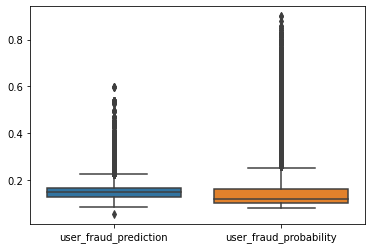

In [23]:
sns.boxplot(data=uf_res)

<AxesSubplot:xlabel='user_fraud_prediction', ylabel='Count'>

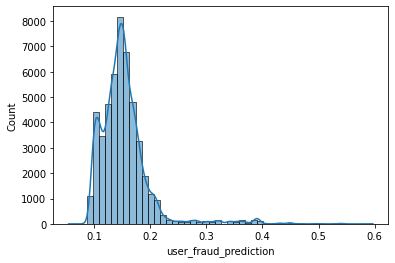

In [24]:
sns.histplot(x='user_fraud_prediction', data=uf_res, kde=True, bins=50)

<AxesSubplot:xlabel='user_fraud_probability', ylabel='Count'>

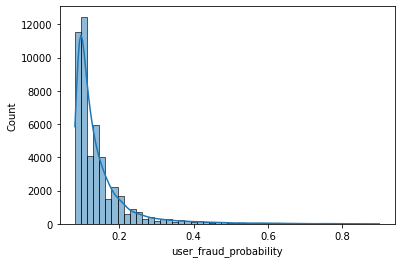

In [25]:
sns.histplot(uf_res['user_fraud_probability'], kde=True, bins=50)

User fraud predctions on test data

In [26]:
uf_pred_test = uf_model.transform(ufTestData)

uf_res_test = uf_pred_test.select(['user_fraud_prediction', 'user_fraud_probability']).toPandas()

<AxesSubplot:>

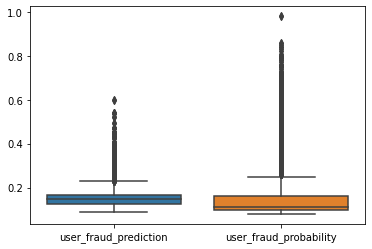

In [27]:
sns.boxplot(data=uf_res_test)

<AxesSubplot:xlabel='user_fraud_prediction', ylabel='Count'>

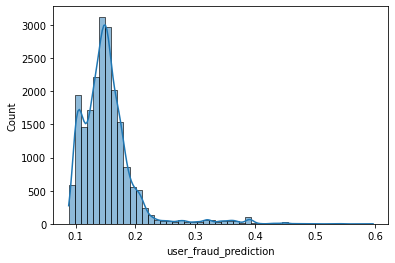

In [28]:
sns.histplot(x='user_fraud_prediction', data=uf_res_test, kde=True, bins=50)

<AxesSubplot:xlabel='user_fraud_probability', ylabel='Count'>

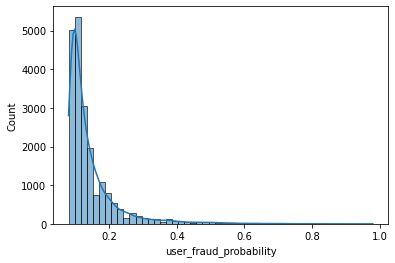

In [29]:
sns.histplot(uf_res_test['user_fraud_probability'], kde=True, bins=50)

Merchant fraud predictions on training data

<AxesSubplot:>

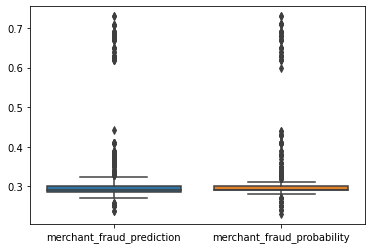

In [30]:
sns.boxplot(data=mf_res)

<AxesSubplot:xlabel='merchant_fraud_prediction', ylabel='Count'>

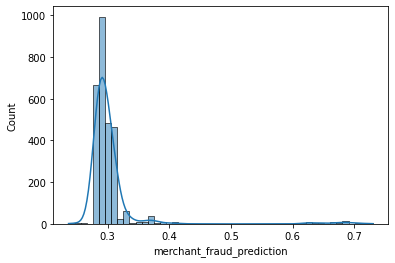

In [31]:
sns.histplot(x='merchant_fraud_prediction', data=mf_res    , kde=True, bins=50)

<AxesSubplot:xlabel='merchant_fraud_probability', ylabel='Count'>

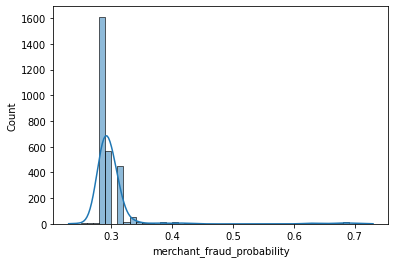

In [32]:
sns.histplot(mf_res['merchant_fraud_probability'], kde=True, bins=50)

Merchant fraud predictions on test data

In [33]:
mf_pred_test = mf_model.transform(mfTestData)
mf_res_test = mf_pred_test.select(['merchant_fraud_prediction', 'merchant_fraud_probability']).toPandas()


<AxesSubplot:>

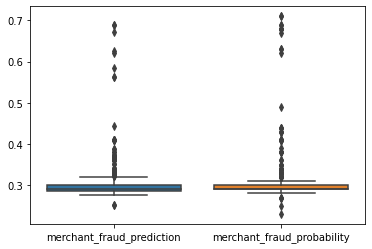

In [34]:
sns.boxplot(data=mf_res_test)

<AxesSubplot:xlabel='merchant_fraud_prediction', ylabel='Count'>

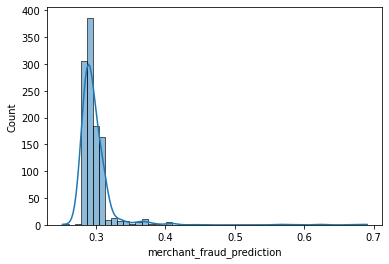

In [35]:
sns.histplot(x='merchant_fraud_prediction', data=mf_res_test, kde=True, bins=50)

<AxesSubplot:xlabel='merchant_fraud_probability', ylabel='Count'>

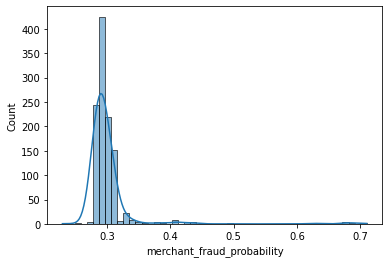

In [36]:
sns.histplot(x='merchant_fraud_probability', data=mf_res_test, kde=True, bins=50)

TODO:
* Add RMSE / AMSE calculations
* Apply to entire dataset

In [37]:
#master = spark.read.parquet('../../../data/curated/process_data.parquet').select(*subset).sample(fraction=0.05, withReplacement=False)

#master = spark.read.parquet('../../../data/curated/process_data.parquet').sample(fraction=0.05, withReplacement=False)
master = spark.read.parquet('../../../data/curated/process_data.parquet')


In [38]:
import time


# vectorize master
start = time.time()
master_v = get_dummy(master,
                     continuousCols=list(continous_cols),
                     categoricalCols=list(categorical_cols),
                     master=True)

print("Took {} seconds for {} rows".format(time.time() - start, master.count()))

#master_v.limit(5)

# DROP INDEXED
# DROP ENCODED

Took 2.2497498989105225 seconds for 13520627 rows


In [39]:
# predict user probs from feature column
master_fitted = mf_model.transform(master_v)
master_fitted = uf_model.transform(master_fitted)

IllegalArgumentException: requirement failed: Column merchant_fraud_prediction already exists.

In [ ]:
master_fitted.limit(10)

22/10/06 21:47:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,state,postcode,gender,merchant_name,tag,revenue,rate,category,subcategory,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg,features,merchant_fraud_prediction,user_fraud_prediction
45466221547,408558,23807,10.37,00006afe-5648-4c0...,2022-07-09,NSW,2256,Female,Eu LLC,"computers, comput...",b,0.0349,retail_and_wholes...,household_goods_r...,null,null,51060,26619.0,58455.75,1.528352959E9,47194.75,47.0,"(8,[1,5,6,7],[1.0...",0.3005225374117386,0.21449423227354517
19054547079,273574,18856,99.31,0001533f-1a2a-4a5...,2021-12-14,WA,6315,Male,Tincidunt Adipisc...,"gift, card, novel...",a,0.0665,retail_and_wholes...,department_stores,null,null,9243,6039.0,70715.5,4.26666905E8,54874.5,47.5,"(8,[0,4,6,7],[1.0...",0.28560216337207733,0.1686003888259078
86406618443,274589,13937,77.58,00015481-01ff-4ac...,2021-09-25,QLD,4072,Male,Tincidunt Pede Ac...,digital goods: bo...,a,0.0656,retail_and_wholes...,household_goods_r...,null,null,13782,5674.0,82025.0,4.65407055E8,41999.0,37.0,"(8,[0,4,6,7],[1.0...",0.28521397093565876,0.19712927609203165
94493496784,224491,998,107.99,00015bab-8017-462...,2021-10-14,VIC,3622,Male,Dictum Phasellus ...,"gift, card, novel...",a,0.0565,retail_and_wholes...,department_stores,null,null,29955,17488.0,50043.333333333336,8.95900632E8,44093.0,46.666666666666664,"(8,[0,4,6,7],[1.0...",0.3099259683941991,0.1649414825012848
32605756719,180184,22990,162.61,00015d52-5218-45d...,2021-11-30,NSW,2345,Male,In Ornare Industries,digital goods: bo...,a,0.0657,retail_and_wholes...,household_goods_r...,null,null,19200,10646.0,49642.0,5.28493249E8,44459.0,47.0,"(8,[0,4,6,7],[1.0...",0.28154613634402376,0.1491242600470761
94493496784,1473258,6094,274.26,00022380-b555-425...,2021-09-17,NSW,2749,Male,Dictum Phasellus ...,"gift, card, novel...",a,0.0565,retail_and_wholes...,department_stores,null,null,30951,16425.0,66170.0,1.08684316E9,59472.0,37.0,"(8,[0,4,6,7],[1.0...",0.3100445399353023,0.13544993185266635
59162205130,384848,13087,303.79,0002a2b0-ea7a-486...,2021-10-16,WA,6308,Female,Ante Dictum LLC,motor vehicle sup...,c,0.0147,retail_and_wholes...,others_retailing,null,null,7955,5168.0,73714.0,3.82063955E8,55999.5,48.0,"(8,[2,5,6,7],[1.0...",0.29004468424319346,0.1670436017777142
39542524740,1110560,4222,22.82,0003871c-0bd8-4d9...,2022-04-22,QLD,4427,Female,Urna Ut Tincidunt...,digital goods: bo...,a,0.0651,retail_and_wholes...,household_goods_r...,null,null,10141,5496.0,43917.5,2.4142693E8,40509.0,45.0,"(8,[0,5,6,7],[1.0...",0.2833963309104175,0.14783854065551355
49891706470,635993,18782,8.39,00044c69-43c0-442...,2022-06-16,QLD,4475,Male,Non Vestibulum In...,tent and awning s...,a,0.058,retail_and_wholes...,department_stores,null,null,2630,1402.0,43196.0,6.0561087E7,43349.0,46.0,"(8,[0,4,6,7],[1.0...",0.649987351902079,0.147112698049168
38090089066,1347759,22405,347.4,0007a624-475d-45e...,2022-05-17,VIC,3294,Male,Interdum Feugiat ...,"furniture, home f...",b,0.0324,retail_and_wholes...,household_goods_r...,null,null,6026,3748.0,55594.0,2.0836768E8,45499.0,50.0,"(8,[1,4,6,7],[1.0...",0.3103784222236628,0.1594107681660512


In [ ]:
# drop features column
master_final = master_fitted.drop('features')

In [ ]:
#master_final.limit(10)

In [ ]:
# add outliers column for user and merchant

In [ ]:
#master_final.printSchema()

In [ ]:
#master_final.orderBy(F.desc('user_fraud_prediction')).limit(10)
#master_final.orderBy(F.desc('merchant_fraud_prediction')).limit(10)

In [ ]:
cols = ["user_fraud_prediction", "merchant_fraud_prediction"]

In [ ]:
bounds = {
    c: dict(
        zip(["q1", "q3"], master_final.approxQuantile(c, [0.25, 0.75], 0.01))
    )
    for c in cols
}

for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)

In [ ]:
bounds

{'user_fraud_prediction': {'q1': 0.1420700661820841,
  'q3': 0.17085187468200433,
  'lower': 0.09889735343220374,
  'upper': 0.21402458743188468},
 'merchant_fraud_prediction': {'q1': 0.2852929290914983,
  'q3': 0.3236965016054774,
  'lower': 0.22768757032052958,
  'upper': 0.3813018603764461}}

In [ ]:
# add outlier col to master

In [ ]:
master_wfraud_col = master_final.select(
    "*",
    *[
        F.when(
            F.col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            0
        ).otherwise(1).alias(c+"_out")
        for c in cols
    ]
)

master_wfraud_col = master_wfraud_col.select(
    "*",
    *[
        F.when(
            (F.col('user_fraud_prediction_out') != 1) | (F.col('merchant_fraud_prediction_out') != 1),
            0
        ).otherwise(1).alias('isfraud')
    ]
)

# drop unneeded cols
master_wfraud_col = master_wfraud_col.drop(*['user_fraud_prediction_out', 'merchant_fraud_prediction_out'])


In [ ]:
#master_wfraud_col.limit(10)

In [ ]:
#master_wfraud_col.where(master_wfraud_col['user_fraud_prediction_out'] > 0).count()

In [ ]:
# these are the fraudulent values
master_wfraud_col.where(master_wfraud_col['isfraud'] > 0).count()

119036

In [ ]:
master_wfraud_col.count()

13614156

In [ ]:
master_ = master_wfraud_col.where(master_wfraud_col['isfraud'] == 0)
master_.count()

13495120